In [1]:
import music21 as ms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [3]:
mfile = ms.converter.parse('midi_export.mid')

In [4]:
mChords = mfile.chordify()

Take the list of PC-Sets, Prime forms and Interval Vectors of the midi file :

In [5]:
chordList = []
chordPrime = []
chordVectors = []
for c in mChords.recurse().getElementsByClass('Chord'):
    chordList.append(c.orderedPitchClasses)
    chordPrime.append(c.primeFormString)
    chordVectors.append(c.intervalVector)

In [6]:
len(chordPrime), len(chordList), len(chordVectors)

(17, 17, 17)

Remove non connected Chords based on primeform list : 

In [7]:
def removeNonConnected(l1,l2):
    nl1 = l1
    nl2 = []
    j = 0
    for i in l2:
        if (
            i == '<047>' or i == '<037>' or i == '<036>' or i == '<048>' or i == '<0358>' or i == '<0146>' or i == '<0158>' 
            or i == '<0258>' or i == '<0369>'
        ):
            nl2.append(i)
            j += 1
        else :
            del nl1[j]            
    return nl1, nl2


In [8]:
def removeNonConnected2(l1, l2):
    nl1 = l1
    nl2 = []
    j = 0
    for i in l2:
        if (
           sum(i) - 2*(i[2] + i[3] + i[4]) <= 0 
        ):
            nl2.append(i)
            j += 1
        else :
            del nl1[j]            
    return nl1, nl2

In [9]:
chordListConnect, primeListConnect = removeNonConnected2(chordList, chordVectors)
len(chordListConnect), len(primeListConnect)

(14, 14)

In [10]:
len(removeNonConnected2(chordList, chordVectors))

2

### Define some functions on calculation optimal distance between chords

Check distance on Interval Vectors strings :

In [11]:
def check(stringVec):
    value = 0
    if stringVec == "<000000>" :
        value = 0
    elif stringVec == "<001000>" : 
        value = 1
    elif stringVec == "<000100>" : 
        value = 1
    else : 
        value = 2
    return value

Build a Cartesian product of distaces between chords :

In [12]:
def mat(l1, l2):
    m2 = [
            ([ (check((ms.chord.Chord([i, j])).intervalVectorString)) for i in l1 ]) for j in l2
         ]
    return m2

Build an 3D-matrix of distances between two consecutive chords

In [13]:
def distance_matrix(listOfChords):
    l1 = []
    l2 = []
    for x in range(1,len(listOfChords)):
        n = listOfChords[x-1]
        m = listOfChords[x]
        matrix = mat(n, m)
        l1.append([sum([row[i] for row in matrix]) for i in range(0,len(n))])
        l2.append(list(map(sum, matrix)))
    return l1, l2

Compute all the distances of two consecutive chords per note. Essentially getting the sum of the row and the collumn for a 2D ChordToChord matrix

In [14]:
dst1, dst2 = distance_matrix(chordListConnect)
print(dst1)
print(dst2)


[[3, 5, 6], [5, 6, 4], [6, 3, 5, 6], [6, 3, 5], [5, 6, 6], [5, 2, 4], [4, 5, 4], [5, 6, 6], [8, 4, 5, 6], [6, 6, 3, 5]]
[[3, 6, 5], [3, 5, 5, 2], [5, 8, 7], [6, 5, 3], [6, 6, 5], [4, 2, 5], [5, 4, 4], [2, 6, 5, 4], [5, 4, 8, 6], [8, 7, 5]]


Getting the index of the minimum element

In [15]:
def noteindex(l):
    k = []
    for i in l:
        k.append(i.index(min(i)))
    return k

Indexing the minimum in collumns and row. That means that I specify the two notes that are closer apart in the Tonnetz grid

In [16]:
listindexN     = noteindex(dst1)
listindexNpls1 = noteindex(dst2)

In [17]:
listOfConnectedNotes = []
for x in range(0,len(chordListConnect)-1):
    k1 = chordListConnect[x]
    k2 = chordListConnect[x+1]
    c1 = k1[listindexN[x]]
    c2 = k2[listindexNpls1[x]]
    listOfConnectedNotes.append((c1,c2))

Here I can find when two graphs are connected or have a bigger distance.

In [18]:
print(listOfConnectedNotes)

[(0, 0), (9, 9), (2, 2), (7, 7), (0, 9), (5, 5), (1, 4), (0, 0), (2, 5), (7, 7)]


Get the interval Vector of previous list :

In [19]:
intervalVectorsOfConnectedNotes = []
for i in listOfConnectedNotes:
    intervalVectorsOfConnectedNotes.append((ms.chord.Chord(i).intervalVectorString))

In [20]:
print(intervalVectorsOfConnectedNotes)
print(len(listOfConnectedNotes))
print(chordListConnect)

['<000000>', '<000000>', '<000000>', '<000000>', '<001000>', '<000000>', '<001000>', '<000000>', '<001000>', '<000000>']
10
[[0, 4, 7], [0, 5, 9], [0, 2, 6, 9], [2, 7, 11], [0, 4, 7], [2, 5, 9], [1, 5, 8], [0, 4, 9], [0, 2, 5, 8], [2, 5, 7, 11], [0, 4, 7]]


In [23]:
buildGrid = ((0, 0), (1, 3), (2, 2), (0, 1), (1, 0), (3, 3), (0, 2), (1, 1), (2, 0), (0, 3), (1, 2), (2, 1))

### In this Section we calculate the position of chords by pairs based on the two closer points

The list of distances

In [47]:
def calculateIntervals(coordX, coordY, num):
        output = 0
        if num==0:
            output = (coordX,coordY)
        elif num == 1 :
            output = (coordX+2, coordY+1)
        elif num == 2 :
            output = (coordX+2, coordY + 2)
        elif num==3:
            output = (coordX, coordY + 1)
        elif num==4:
            output = (coordX+1, coordY)
        elif num==5 :
            output = (coordX-1, coordY-1)
        elif num==7 :
            output = (coordX+1, coordY+1)
        elif num == 8 :
            output = (coordX-1, coordY)
        elif num == 9 :
            output = (coordX, coordY-1)
        elif num == 10 :
            output = (coordX-2, coordY-1)
        else :
            output = (coordX-1, coordY +1)
        return output

We define the notion of distance

In [48]:
def defineDistance(coord, l, number):
    coordX = coord[0]
    coordY = coord[1]
    nl = []
    for i in l:
        i = (i - number)%12
        nl.append(calculateIntervals(coordX, coordY, i))
    return nl

We calculate the Coordinates for a pair of chords

In [49]:
def chordPairCoord(axes, chords, minIndex):
    ad1 = chords[0]
    ad2 = chords[1]
    k1 = minIndex[0]
    k2 = minIndex[1]
    setCoord1 = axes
    newcoord = (k2-k1)%12
    setCoord2 = calculateIntervals(setCoord1[0], setCoord1[1], newcoord)    
    a1 = defineDistance(setCoord1, ad1, k1)
    a2 = defineDistance(setCoord2, ad2, k2)
    return a1, a2

We get the cordinates for two consecutive chords and we build a list of all the pairs in the original chord sequence

In [50]:
def getCoordinatesByPairs(listofChords, listofIndexes):
    axes = (0,0)
    l = []
    for i in range(1, len(listofIndexes)):
        listof = [listofChords[i-1], listofChords[i]]
        setindex = listofIndexes[i-1]
        l.append(chordPairCoord(axes, listof, setindex))
        axesdif = listofIndexes[i][0] - listofIndexes[i-1][1]% 12
        axes =  calculateIntervals(axes[0], axes[1], axesdif)
    return l

We remind the list of the notes between consecutive chords with the optimal distance

In [51]:
listOfConnectedNotes

[(0, 0),
 (9, 9),
 (2, 2),
 (7, 7),
 (0, 9),
 (5, 5),
 (1, 4),
 (0, 0),
 (2, 5),
 (7, 7)]

In [57]:
TotalCoordinates = getCoordinatesByPairs(chordList,listOfConnectedNotes)
TotalCoordinates

[([(0, 0), (1, 0), (1, 1)], [(0, 0), (-1, -1), (0, -1)]),
 ([(0, 0), (-1, -1), (0, -1)], [(0, 0), (-1, -2), (0, -2), (0, -1)]),
 ([(-3, -1), (-1, 0), (0, 0), (0, 1)], [(-1, 0), (-2, -1), (-1, -1)]),
 ([(-1, 0), (-2, -1), (-1, -1)], [(-3, -2), (-2, -2), (-2, -1)]),
 ([(-3, 0), (-2, 0), (-2, 1)], [(-4, -2), (-4, -1), (-3, -1)]),
 ([(-4, 0), (-4, 1), (-3, 1)], [(-5, 1), (-4, 1), (-4, 2)]),
 ([(-5, 2), (-4, 2), (-4, 3)], [(-6, 3), (-5, 3), (-6, 2)]),
 ([(-6, 3), (-5, 3), (-6, 2)], [(-6, 3), (-4, 5), (-7, 2), (-7, 3)]),
 ([(-6, 4), (-4, 5), (-4, 6), (-5, 6)], [(-4, 5), (-4, 6), (-2, 8), (-5, 7)])]

We should filter any changes between the last element of a pair and the first of the next one. They should be identical

In [72]:
listofCoordinatePoints = []
for i in TotalCoordinates:
    for j in i[0] : 
            listofCoordinatePoints.append(j)
    for j in i[1] : 
            listofCoordinatePointsX.append(j)
            
TotalPoints = set(listofCoordinatePoints)
print(TotalPoints)


{(-4, 5), (-1, 0), (-2, 0), (-3, -1), (-6, 3), (-4, 2), (-4, 6), (-2, 1), (-4, 3), (-6, 4), (-2, -1), (-1, -1), (1, 1), (0, 0), (-3, 1), (-4, 0), (1, 0), (-5, 3), (0, 1), (-3, 0), (-6, 2), (-5, 6), (-4, 1), (0, -1), (-5, 2)}


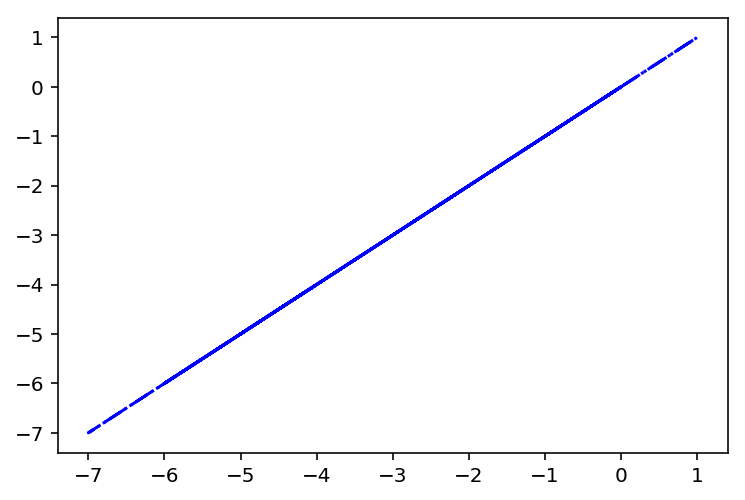

We place the first chord in the grid we defined earlier. The $x$ and $y$ are the placement of a moving box containing the original grid. $k$ signifies the chord we want to place in the grid.

In [54]:
def placeFirstChordInGrid(l, k, grid, x, y):
    coordinates = []
    for i in l[k]:
        coordinates.append(((grid[i])[0]+x, (grid[i])[1]+y))
    return coordinates

In [55]:
placeFirstChordInGrid(chordListConnect, 0, buildGrid, 0, 0)

[(0, 0), (1, 0), (1, 1)]

In [133]:
points = np.array(placeFirstChordInGrid(chordListConnect, 0, buildGrid, 0, 0))
tri = Delaunay(points)

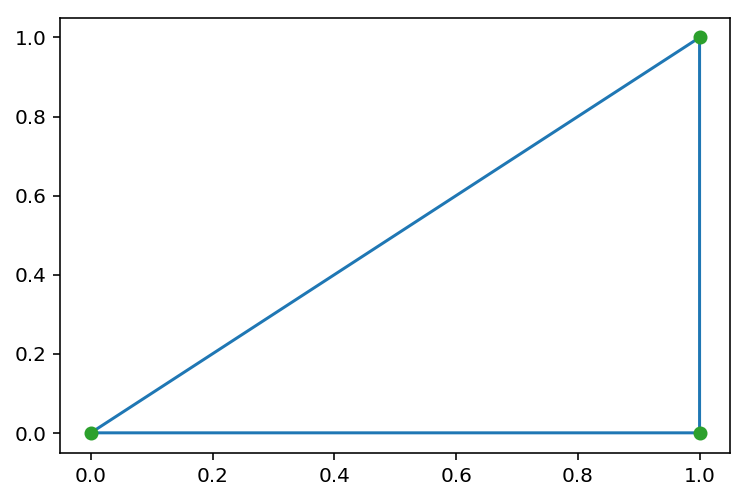

In [134]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

True